In [1]:
import math
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# activation should be some kind function name as F.relu, F.tanh
# this Layer may be realized directly by nn.Module
class Layer(nn.Module):
    def __init__(self, D_in, D_out, activation):
        super(Layer,self).__init__()
        self.linear = nn.Linear(D_in, D_out)
        self.activation = activation            #F.relu
        
    def forward(self, x):
        if self.activation is None:
            return self.linear(x)
        else: 
            return self.activation(self.linear(x))
    
#Test code example
#l1 = Layer(3,5, F.relu)
#l1(t.randn(10,3))
#or l1.forward(t.randn(10,3))

In [3]:
# KL divergence for encoder's cost
# mu.shape[1] : the dimension of mu 
EPS = 0.001

def KL_mvn(mu, var):
    return (mu.shape[1] + t.sum(t.log(var), dim=1) - t.sum(mu**2, dim=1) - t.sum(var, dim=1)) / 2.0

# For decoder's cost
def log_diag_mvn(mu, var):
    def f(x):
        k = mu.shape[1]
        log_p = (-k / 2.0) * math.log(2 * math.pi) - 0.5 * t.sum(t.log(var), dim=1) - t.sum(0.5 * (1.0 / var) * (x - mu) * (x - mu), dim=1)
        return log_p
    return f

In [6]:
class Encoder(nn.Module):
    def __init__(self, layer_sizes, activations):
        super(Encoder, self).__init__()
        # add layers to the network
        self.layers = []
        for n_input, n_output, activation in zip(layer_sizes[:-2], layer_sizes[1:-1], activations[1:-1]):
            self.layers.append(Layer(n_input, n_output, activation))
            
        #MLP Gaussian encoder 
        self.mu_layer = Layer(layer_sizes[-2], layer_sizes[-1], None)
        self.logvar_layer = Layer(layer_sizes[-2], layer_sizes[-1], None)
        
        
    def forward(self, x, eps):
        # tow outputs 
        inp = x
        for layer in self.layers:
             x = layer.forward(x)
        
        mu = self.mu_layer.forward(x)
        var = t.exp(self.logvar_layer.forward(x))
        sigma = t.sqrt(var)
        
        # reparametrization trick
        self.output = mu + sigma * eps
        self.cost = -t.sum(KL_mvn(mu, var))
        return self.output, self.cost

In [7]:
class Decoder(nn.Module):
    def __init__(self, layer_sizes, activations):
        super(Decoder, self).__init__()
        self.layers = []        
        for n_input, n_output, activation in zip(layer_sizes[:-2], layer_sizes[1:-1], activations[1:-1]):
            self.layers.append(Layer(n_input, n_output, activation))
            
        self.mu_layer = Layer(layer_sizes[-2], layer_sizes[-1], None)
        self.logvar_layer = Layer(layer_sizes[-2], layer_sizes[-1], None)
        
    def forward(self, x, y):
        inp = x
        for layer in self.layers:
             x = layer.forward(x)

        mu = self.mu_layer.forward(x)
        var = t.exp(self.logvar_layer.forward(x))
        sigma = t.sqrt(var)
        
        # decoder cost function
        self.mu = mu
        self.var = var
        self.output = mu
        self.cost = -t.sum(log_diag_mvn(self.output , var)(y))
        return self.output, self.cost

In [8]:
class VAE(nn.Module):
    def __init__(self, enc_layer_sizes, dec_layer_sizes, enc_activations, dec_activations):
        super(VAE, self).__init__()
        self.enc_mlp = Encoder(enc_layer_sizes, enc_activations)
        self.dec_mlp = Decoder(dec_layer_sizes, dec_activations)
        
    def forward(self, x, eps):
        e_cost = self.enc_mlp.forward(x, eps)[1]
        d_cost = self.dec_mlp.forward(self.enc_mlp.forward(x, eps)[0], x)[1]
        return e_cost + d_cost

Test the VAE architecture with a simple example: a curve with Gaussian noise   

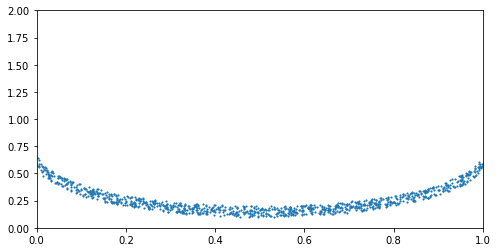

In [9]:
t.manual_seed(10)
N = 1000
X1 = t.rand(N, requires_grad = True)
X = t.transpose(t.stack((X1, -1.0*t.sqrt(0.25 - (X1-0.5)**2) +0.6 + 0.1*t.rand(N)), dim = 0 ), 0, 1)
plt.figure(figsize = (8,4))
#plt.plot(X[:, 0].data.numpy(), X[:, 1].data.numpy())
plt.scatter(X[:, 0].data.numpy(), X[:, 1].data.numpy(), linewidths =.3, s=3, cmap=plt.cm.cool)
plt.axis([0, 1, 0, 2])
plt.show()
#X.shape[0]

In [16]:
# declare the model 
enc_layer_sizes = [X.shape[1], 10, 10, 10, 1]
enc_activations = [None, F.tanh, F.tanh, None, None]

dec_layer_sizes = [enc_layer_sizes[-1], 10, 10, 10, X.shape[1]]
dec_activations = [None, None, F.tanh, F.tanh, None]

model = VAE(enc_layer_sizes, dec_layer_sizes, enc_activations, dec_activations)

In [17]:
# parameters 
lr = 0.001
batch_size = 100
epochs = 1000
num_batch = X.shape[0]/ batch_size

# optimizer
optimizer = t.optim.Adam(model.parameters(), lr=lr)

# training loop 
for i in range(int(epochs * num_batch)):
    k = i % num_batch
    x = X[int(k * batch_size):int((k+1) * batch_size), :]
    eps = t.rand(x.shape[0],enc_layer_sizes[-1], requires_grad = True)
    
    # loss function
    loss = model.forward(x, eps)
    
    # backpropagation 
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if i%200 ==0:
        print(loss.data)

tensor(192.8457)
tensor(119.8480)
tensor(68.9149)
tensor(25.2695)
tensor(-25.1000)
tensor(-56.5756)
tensor(-86.3229)
tensor(-96.2779)
tensor(-120.6112)
tensor(-121.7070)
tensor(-132.9432)
tensor(-136.0933)
tensor(-151.9892)
tensor(-153.3959)
tensor(-167.7629)
tensor(-164.1511)
tensor(-180.3418)
tensor(-185.3131)
tensor(-214.5855)
tensor(-218.4832)
tensor(-221.3182)
tensor(-224.6881)
tensor(-224.1922)
tensor(-217.0706)
tensor(-241.9244)
tensor(-240.7706)
tensor(-231.7773)
tensor(-245.6914)
tensor(-228.3418)
tensor(-225.1387)
tensor(-231.1369)
tensor(-237.6461)
tensor(-231.6447)
tensor(-232.2560)
tensor(-233.2654)
tensor(-226.6514)
tensor(-241.7902)
tensor(-242.2083)
tensor(-249.4384)
tensor(-243.7425)
tensor(-234.0250)
tensor(-234.0633)
tensor(-243.9621)
tensor(-243.6463)
tensor(-247.2762)
tensor(-231.3341)
tensor(-235.7959)
tensor(-244.8285)
tensor(-249.3563)
tensor(-235.0660)


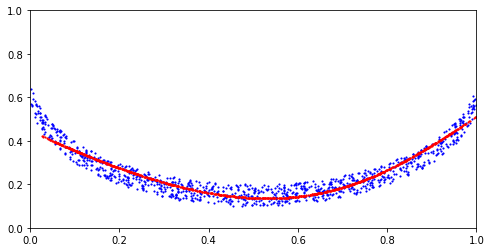

In [18]:
# reconstruct the data with trained model
eps = t.rand(X.shape[0],enc_layer_sizes[-1], requires_grad = True)
Z = model.enc_mlp(X, eps)[0]
X_projected = model.dec_mlp(Z, X)[0]

plt.figure(figsize = (8,4))
plt.scatter(X[:, 0].data.numpy(), X[:, 1].data.numpy(), c='blue', lw=.3, s=3)
plt.scatter(X_projected[:, 0].data.numpy(), X_projected[:, 1].data.numpy(), c='red', lw=.3, s=3)
plt.axis([0, 1, 0, 1])
plt.show()